<h1>Australian Cities clustering using population and venues</h1>
<h4>Lahiri Bellarykar</h4>

<p>Australia is big country. For an outside traveler it is difficult to know what to expect.</p>
<p>A Traveler commonly knows a bit about new country and its well known cities/towns. This prior knowledge can be augmented with a Data science based solution to help traveler plan a trip better.</p>
<p>
<h4>Data source: To create a Data science based solution we use multiple data sources as listed below</h4>
<ul>
<li>1. Australia city data from wikipedia</li>
<li>2. Australian city latitude and longitude from <b>geopy</b></li>
<li>3. Venues in Australian cities from <b>Foursqare API</b></li>
</ul>
</p>

In [2]:
#import libraries
import pandas as pd
from geopy.geocoders import Nominatim
import requests
from json import load

<h3>Data collection</h3>

In [3]:

#Scrape major cities in Austraila from wikipedia
url = 'https://en.wikipedia.org/wiki/List_of_cities_in_Australia_by_population'

#use pandas to read the tables in url
au_cities = pd.read_html(url)

#Convert scraped tabel to pandas dataframe
df_au_city = pd.DataFrame(au_cities[1])
df_au_city.reset_index(drop =True, inplace = True)

#fix column names.
df_au_city.columns=['Rank','Significant Urban Areas','State','Population2019','Population2011','Growth','percent_of_national_population']

<p><b>Australian cities data scraped from wikipedia</p>

In [4]:
df_au_city.head()

,Rank,Significant Urban Areas,State,Population2019,Population2011,Growth,percent_of_national_population
0,1,Sydney,New South Wales,4914343,4231954,+19.10%,20.93%
1,2,Melbourne,Victoria,4893870,3999982,+24.08%,19.86%
2,3,Brisbane,Queensland,2430180,2065996,+19.20%,9.85%
3,4,Perth,Western Australia,2045479,1728867,+19.12%,8.24%
4,5,Adelaide,South Australia,1340794,1262940,+6.56%,5.38%


In [35]:
#Get latitude and longitude for each Australian city in df_au_city

df_au_city_lat_lng = pd.DataFrame(columns=['City','Latitude','Longitude'])
list_city = []
list_lat  = []
list_lng  = []

for city in df_au_city["Significant Urban Areas"]:
    address = '{}, {}'.format(city, 'AU')
    geolocator = Nominatim(user_agent='Australia_explorer')
    location = geolocator.geocode(address)
    if(location is not None):
        lat = location.latitude
        lng = location.longitude
        list_city.append(city)
        list_lat.append(lat)
        list_lng.append(lng)
    

df_au_city_lat_lng['City'] = list_city
df_au_city_lat_lng['Latitude'] = list_lat
df_au_city_lat_lng['Longitude'] = list_lng

<p><b>Get Latitude and Longitude of each Australian city using geopy</p>

In [36]:
df_au_city_lat_lng.head()

,City,Latitude,Longitude
0,Sydney,-33.854816,151.216454
1,Melbourne,-37.814218,144.963161
2,Brisbane,-27.468968,153.023499
3,Perth,-31.952712,115.860480
4,Adelaide,-34.928181,138.599931


In [8]:
#Get venues for each Australian City using latitude and longitude in df_au_city_lat_lng

#Set Foursquare credentials 
CLIENT_ID='CMK42VYK5QGAICWXQZNMF2U4SH0VAU3AN05OZJMZK3WI5NWQ'
CLIENT_SECRET='XG1WH1D0GXKMEHTBRZW3I5OGGIGIKORBA3CPLO50BUUYB1ZZ'

#Set common Foursquare API parameters
radius = 500
limit=100
version = 20203112

#Australian city and venues dataframe 
df_Aus_city_venues = pd.DataFrame(columns=['city','venue_cat'])


for city, city_lat, city_lng in zip(df_au_city_lat_lng['City'], df_au_city_lat_lng['Latitude'], df_au_city_lat_lng['Longitude'] ):
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&radius={}&limit={}&ll={},{}&v={}'.format(CLIENT_ID,CLIENT_SECRET,radius,limit,city_lat,city_lng,version)
    result = requests.get(url).json()

    city_name = city
    latitude = city_lat
    longitude = city_lng
    list_category = []
    list_city = []
    list_lat = []
    list_lng = []
    count = 0
    
    #get the number of venues returned in response to API call.
    venue_loop_len = len(result.get('response').get('venues'))
    for count in range(venue_loop_len):
        if((result.get('response').get('venues')[count].get('categories') == [])):
            #print(d.get('response').get('venues')[count].get('categories'))
            category_name = 'Not assigned'
        else:
            category_name = result.get('response').get('venues')[count].get('categories')[0].get('name')
        list_category.append(category_name)
        list_city.append(city_name)
        count += 1
        
    city_categories = pd.DataFrame([list_city, list_category]).transpose()
    city_categories.columns = ['city','venue_cat']
    
    #New row with one postal code and multiple neighbourhoods is added to the dataframe.
    df_Aus_city_venues = df_Aus_city_venues.append(city_categories, ignore_index=True)

<p><b>Get Venues data for each Australian city</p>

In [37]:
df_Aus_city_venues.columns=['City','venue_cat']
df_Aus_city_venues.head()

,City,venue_cat
0,Sydney,Bubble Tea Shop
1,Sydney,Furniture / Home Store
2,Sydney,Opera House
3,Sydney,Boat or Ferry
4,Sydney,Restaurant


<h3>Data visualization</h3>

<p><b>Here we have collected data for Austrlian cities its graphical representation is as below.</p>

In [10]:
import folium
#Get lat lng of Australia 
address = 'Australia'
geolocator = Nominatim(user_agent="Australia_country")
location = geolocator.geocode(address)
au_lat = location.latitude
au_lng = location.longitude
print(lat, lng)

-26.5412563 151.8394231


In [11]:
Australia_map = folium.Map(location=[au_lat,au_lng], zoom_start=4)

for lat, lng, citi in zip(df_au_city_lat_lng['Latitude'], df_au_city_lat_lng['Longitude'], df_au_city_lat_lng['City']):
    label = '{}'.format(citi)
    label = folium.Popup(label,parse_html=True)
    
    folium.CircleMarker(
        [lat,lng],
        radius = 5,
        popup = label,
        color = 'blue',
        fill = True,
        fill_color = 'green',
        fill_opacity = '0.7',
        parse_html = False
    ).add_to(Australia_map)
Australia_map

<h3>Data cleaning</h3>

<p>The data however needs to be cleaned up so that it can be used to cluster Australian cities.</p>

In [44]:
import numpy as np

In [13]:
#Cleaup data scraped from wikipedia
df_au_city.head()

#drop field Population2011 from df_au_city as it does not add any value to clustering, Population2019 does
df_au_city.drop('Population2011', inplace=True, axis=1)

#Cast Population2019, Growth, percent_of_national_population columns to numeric value for processing
df_au_city.loc[:,('Population2019')] = pd.to_numeric(df_au_city.loc[:,('Population2019')],downcast='integer') 

#remove unwanted symbols from growth column and replace those with correct values.
df_au_city['Growth'] = df_au_city['Growth'].str.replace('+','')
df_au_city['Growth'] = df_au_city['Growth'].str.replace('−','-')
df_au_city['Growth'] = df_au_city['Growth'].str.replace('%','')

df_au_city['percent_of_national_population'] = df_au_city['percent_of_national_population'].str.replace('%','')

df_au_city.loc[:,('Growth')] = pd.to_numeric(df_au_city.loc[:,('Growth')], downcast='float')

df_au_city.loc[:,('percent_of_national_population')] = pd.to_numeric(df_au_city.loc[:,('percent_of_national_population')], downcast='float')

In [14]:
#Cleanup df_Aus_city_venues and remove records for which venues are not found
print('There are total of {} rows in df_Aus_city_venues dataframe for which venue data is Not assigned'.
      format(df_Aus_city_venues[df_Aus_city_venues['venue_cat'] == 'Not assigned'].shape[0]))
df_Aus_city_venues[df_Aus_city_venues['venue_cat'] == 'Not assigned']

There are total of 427 rows in df_Aus_city_venues dataframe for which venue data is Not assigned


,City,venue_cat
20,Sydney,Not assigned
28,Sydney,Not assigned
134,Melbourne,Not assigned
135,Melbourne,Not assigned
138,Melbourne,Not assigned
...,...,...
8350,Swan Hill,Not assigned
8437,Portland,Not assigned
8439,Portland,Not assigned
8440,Portland,Not assigned


In [15]:
#Lets remove these rows from df_Aus_city_venues
indx_delete = df_Aus_city_venues[df_Aus_city_venues['venue_cat'] == 'Not assigned'].index.values
df_Aus_city_venues.drop(index=indx_delete, inplace=True)
df_Aus_city_venues.shape

(8189, 2)

In [16]:
df_au_city.head()

,Rank,Significant Urban Areas,State,Population2019,Growth,percent_of_national_population
0,1,Sydney,New South Wales,4914343,19.100000,20.930000
1,2,Melbourne,Victoria,4893870,24.080000,19.860001
2,3,Brisbane,Queensland,2430180,19.200001,9.850000
3,4,Perth,Western Australia,2045479,19.120001,8.240000
4,5,Adelaide,South Australia,1340794,6.560000,5.380000


<h3>Data Normalization</h3>
<p><b>We must know nature of features distribution, so that we can correctly apply normalizing or scaling
to the data.</p>
<p><b>Let's check if numeric features have a normal/Gaussian distribution or not.</p>

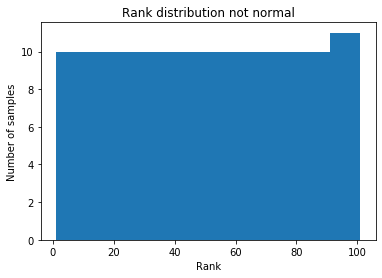

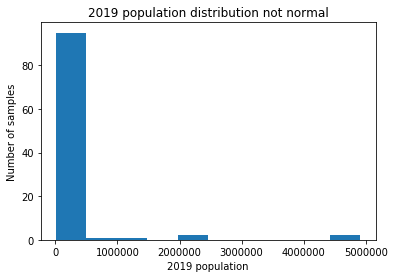

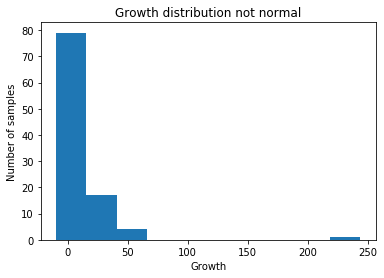

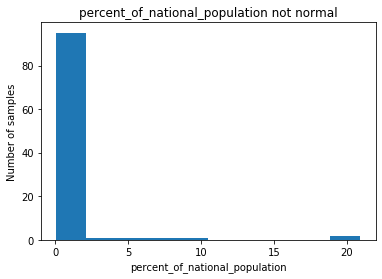

In [18]:
#Data normalization, feature scaling
from matplotlib import pyplot as plt

#Let's check if numeric features are normally distributed or not.

#Rank distribution
plt.hist(df_au_city['Rank'])
plt.title('Rank distribution not normal')
plt.ylabel('Number of samples')
plt.xlabel('Rank')
plt.show()

#Population2019 distribution
plt.hist(df_au_city['Population2019'])
plt.title('2019 population distribution not normal')
plt.ylabel('Number of samples')
plt.xlabel('2019 population')
plt.show()

#Growth distribution
plt.hist(df_au_city['Growth'])
plt.title('Growth distribution not normal')
plt.ylabel('Number of samples')
plt.xlabel('Growth')
plt.show()

#percent_of_national_population distribution
plt.hist(df_au_city['percent_of_national_population'])
plt.title('percent_of_national_population not normal')
plt.ylabel('Number of samples')
plt.xlabel('percent_of_national_population')
plt.show()

#anderson = stats.anderson(df_au_city['Rank'],dist='norm')
#print(anderson)

<p>From the plots above we clearly see that none of these feature distributions are normal distributions. Thus we
normalize these features so that they can be better suited for unsupervised clustering algorithms</p>

In [19]:
#Since these features do not have normal distribution, we can apply Normalization to them
from sklearn import preprocessing
import numpy.core.multiarray

#Normalize Rank
rank_normalizer = preprocessing.Normalizer().fit([df_au_city['Rank']])
rank_normalized = rank_normalizer.transform([df_au_city['Rank']])

#Normalize population
population2019_normalizer = preprocessing.Normalizer().fit([df_au_city['Population2019']])
population2019_normalized = population2019_normalizer.transform([df_au_city['Population2019']])

#Normalize Growth
growth_normalizer = preprocessing.Normalizer().fit([df_au_city['Growth']])
growth_normalized = growth_normalizer.transform([df_au_city['Growth']])

#Normalize percent contribution to Australi's population
percent_of_national_population_normalizer = preprocessing.Normalizer().fit([df_au_city['percent_of_national_population']])
percent_of_national_population_normalized = percent_of_national_population_normalizer.transform([df_au_city['percent_of_national_population']])

df_au_city_normalized_data = pd.DataFrame(columns=['City','State','Rank','Population2019','Growth','percent_of_national_population'])

df_au_city_normalized_data.loc[:,'City'] = df_au_city['Significant Urban Areas']
df_au_city_normalized_data.loc[:,'Rank'] = rank_normalized[0]
df_au_city_normalized_data.loc[:,'State'] = df_au_city['State']
df_au_city_normalized_data.loc[:,'Population2019'] = population2019_normalized[0]
df_au_city_normalized_data.loc[:,'Growth'] = growth_normalized[0]
df_au_city_normalized_data.loc[:,'percent_of_national_population'] = percent_of_national_population_normalized[0]

#Normalized data
df_au_city_normalized_data.head()

,City,State,Rank,Population2019,Growth,percent_of_national_population
0,Sydney,New South Wales,0.001694,0.626183,0.065337,0.645473
1,Melbourne,Victoria,0.003388,0.623575,0.082373,0.612475
2,Brisbane,Queensland,0.005081,0.309652,0.065679,0.303770
3,Perth,Western Australia,0.006775,0.260634,0.065406,0.254118
4,Adelaide,South Australia,0.008469,0.170843,0.022440,0.165917


<h3>Feature selection</h3>
<table style="width:100%">
    <tr>
     <td><b>Features Kept</b></td>
     <td><b>Features droped</b></td>
     <td><b>Reason for dropping</b></td>
    </tr>
    <tr>
     <td>Rank</td>
     <td><b></b></td>
     <td><b></b></td>
    </tr>
    <tr>
     <td>Population2019</td>
     <td><b></b></td>
     <td><b></b></td>
    </tr>
    <tr>
     <td>Growth</td>
     <td><b></b></td>
     <td><b></b></td>
    </tr>
    <tr>
     <td>percent_of_national_population</td>
     <td><b></b></td>
     <td><b></b></td>
    </tr>
    <tr>
     <td>State</td>
     <td></td>
     <td></td>
    </tr>
    <tr>
     <td></td>
     <td>Population2011</td>
     <td>2011 population does not add any new information about a city for clustering the cities</td>
    </tr>
     <tr>
     <td>Venue Categories(there are 477 venue categories)</td>
     <td></td>
     <td></td>
    </tr>
</table>


<h3>Exploratory data analysis</h3>
<p>We consider <b>Population2019, Growth, percent_of_national_population</b> and show relationship of each feature to exercise of grouping/clustering similar cities</p>

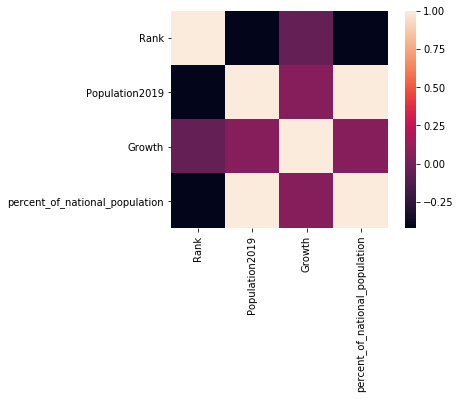

In [20]:
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

df_au_city_normalized_data.describe()
normalized_subset = df_au_city_normalized_data[['Rank','Population2019','Growth','percent_of_national_population']]
correlation = normalized_subset.corr()
sns.heatmap(correlation,square=True)

<p>Looking at above correlation analysis, Population2019 and percent_of_national_population are highly correlated.We can remove <b>percent_of_national_population</b> and keep <b>Population2019</b> as it represents absolute city population which is a good feature for clustering similar cities.</p>

In [21]:
#Drop percent_of_national_population
df_au_city_normalized_data.drop(['percent_of_national_population'],axis=1, inplace=True)

<h3>Feature selection</h3>
<table style="width:100%">
    <tr>
     <td><b>Features Kept</b></td>
     <td><b>Features droped</b></td>
     <td><b>Reason for dropping</b></td>
    </tr>
    <tr>
     <td>Rank</td>
     <td><b></b></td>
     <td><b></b></td>
    </tr>
    <tr>
     <td>Population2019</td>
     <td><b></b></td>
     <td><b></b></td>
    </tr>
    <tr>
     <td>Growth</td>
     <td><b></b></td>
     <td><b></b></td>
    </tr>
    <tr>
     <td></td>
     <td>percent_of_national_population</td>
     <td>High correlation with Population2019 and does not represent any new information useful for clustering cities</td>
    </tr>
    <tr>
     <td>State</td>
     <td></td>
     <td></td>
    </tr>
    <tr>
     <td></td>
     <td>Population2011</td>
     <td>2011 population does not add any new information about a city for clustering the cities</td>
    </tr>
    </tr>
     <tr>
     <td>Venue Categories(there are 477 venue categories)</td>
     <td></td>
     <td></td>
    </tr>
</table>


In [22]:
df_au_city_normalized_data.head()

,City,State,Rank,Population2019,Growth
0,Sydney,New South Wales,0.001694,0.626183,0.065337
1,Melbourne,Victoria,0.003388,0.623575,0.082373
2,Brisbane,Queensland,0.005081,0.309652,0.065679
3,Perth,Western Australia,0.006775,0.260634,0.065406
4,Adelaide,South Australia,0.008469,0.170843,0.022440


In [23]:
#Merge venue details into df_au_city_normalized_data
df_au_city_data = df_au_city_normalized_data[['City','State']].merge(df_Aus_city_venues, how='inner', on='City')

#Onehot encoding for state and venue categories
df_au_city_onehot = pd.get_dummies(df_au_city_data[['State','venue_cat']], prefix="", prefix_sep="")
#toronto_venues_onehot['Neighbourhood'] = df_toronto_venues_data_wrangling['Neighbourhood']
df_au_city_onehot['City'] = df_au_city_data['City']

In [24]:
df_au_city_onehot = df_au_city_onehot.groupby('City').mean()
df_au_city_onehot.reset_index()
df_au_city_onehot = df_au_city_onehot.merge(df_au_city_normalized_data[['City','Rank','Population2019','Growth']], how='inner',on='City')

<p><b>One hot encoding for the categorical features</p>

In [38]:
df_au_city_onehot.head()

,City,Australian Capital Territory/New South Wales,New South Wales,New South Wales/Victoria,Northern Territory,Queensland,Queensland/New South Wales,South Australia,Tasmania,Victoria,...,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Rank,Population2019,Growth
0,Adelaide,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.010638,0.0,0.008469,0.170843,0.022440
1,Albany,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.076222,0.004379,0.039613
2,Albury–Wodonga,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.033876,0.012084,0.047994
3,Alice Springs,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.094854,0.003363,0.018301
4,Armidale,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.010204,0.0,0.098241,0.003132,0.031061


<h3>Modeling/Clustering cities</h3>
<h4>K-Means Clustering</h4>

In [25]:
#Apply KMeans Clustering algorithm
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
#Use K-means to find out the clusters in the data.
#To choose an optimal value of k we use elbow method.

distortions = []
inertias = []

#let's run k means using multiple values of k from 1 to 20
klimit = 20
for k in range(1,klimit):
    clusters = KMeans(n_clusters=k, n_init=20, algorithm='auto').fit(df_au_city_onehot.drop('City',axis=1))
    distortions.append(sum(np.min(cdist(df_au_city_onehot.drop('City',axis=1), clusters.cluster_centers_, 
                      'euclidean'),axis=1)) / df_au_city_onehot.shape[0])
    inertias.append(clusters.inertia_)


<p><b>To find out the best k value we use elbow method</p>

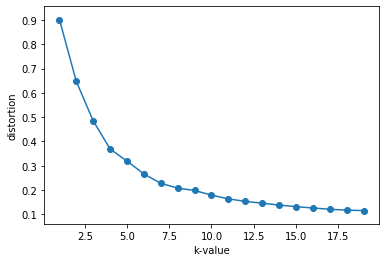

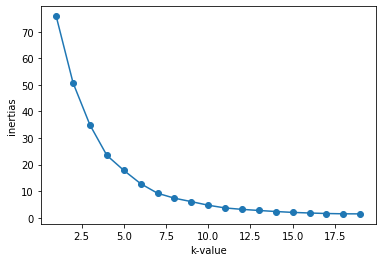

,k-value,distortion,inertias
0,1.0,0.902159,75.844881
1,2.0,0.647091,50.739468
2,3.0,0.484605,34.896753
3,4.0,0.368652,23.463782
4,5.0,0.318934,17.839581
5,6.0,0.265970,12.812896
6,7.0,0.227376,9.211362
7,8.0,0.207663,7.348431
8,9.0,0.197743,6.055151
9,10.0,0.178851,4.700212


In [28]:
df_best_k = pd.DataFrame([range(1,klimit),distortions,inertias]).transpose()
df_best_k.columns=['k-value','distortion','inertias']

#Discover elbow using distortion
plt.scatter(df_best_k['k-value'],df_best_k['distortion'],marker='o')
plt.plot(df_best_k['k-value'],df_best_k['distortion'])
plt.xlabel('k-value')
plt.ylabel('distortion')
plt.show()

#Discover elbow using inertias
plt.scatter(df_best_k['k-value'],df_best_k['inertias'],marker='o')
plt.plot(df_best_k['k-value'],df_best_k['inertias'])
plt.xlabel('k-value')
plt.ylabel('inertias')
plt.show()

df_best_k

<p>Using K-Means algorithm we can see that <b>k=5 is the best solution offered</b>, hence cities are clustered
into 5 distinct categories.</p>
<p>Thus we run <b>K-Means algorithm again using k=5</b> to get the cluster values for the cities.
</p>

In [40]:
#Running K-Means algorithm using k=6
k = 5
k_clusters = KMeans(n_clusters=k, n_init=20, algorithm='auto').fit(df_au_city_onehot.drop('City',axis=1))

In [41]:
df_city_clusters_k_means = pd.DataFrame(columns=['City'])
df_city_clusters_k_means.loc[:,('City')] = df_au_city_onehot.loc[:,('City')]
df_city_clusters_k_means['Cluster'] = k_clusters.labels_

In [42]:
df_city_clusters_k_means  = df_city_clusters_k_means.merge(df_au_city_lat_lng,how='inner',on='City')
df_city_state = df_au_city_normalized_data[['City','State']]
df_city_clusters_k_means = df_city_clusters_k_means.merge(df_city_state, how='inner',on = 'City')
df_city_clusters_k_means

,City,Cluster,Latitude,Longitude,State
0,Adelaide,3,-34.928181,138.599931,South Australia
1,Albany,4,-35.024782,117.883608,Western Australia
2,Albury–Wodonga,3,-36.111876,146.848619,New South Wales/Victoria
3,Alice Springs,3,-23.698388,133.881289,Northern Territory
4,Armidale,1,-30.514488,151.665656,New South Wales
...,...,...,...,...,...
86,Warwick,2,-28.216320,152.032704,Queensland
87,Whyalla,3,-33.050271,137.575884,South Australia
88,Wollongong,1,-34.424394,150.893850,New South Wales
89,Yanchep,4,-31.549942,115.625685,Western Australia


<h4>Having clustered Australian cities based on given data, we can now graphically represent it</h4>

In [54]:
from colormap import rgb2hex
import random

clr = []
for i in range(0,k):
    cl = rgb2hex(random.randint(1,255),random.randint(1,255),random.randint(1,255))
    clr.append(cl)

Australia_map_clustered = folium.Map(location=[au_lat,au_lng], zoom_start=4)

for lat, lng, citi, clstr, state in zip(df_city_clusters_k_means['Latitude'], df_city_clusters_k_means['Longitude'], df_city_clusters_k_means['City'],df_city_clusters_k_means['Cluster'], df_city_clusters_k_means['State']):
    label = '{},{}'.format(state, citi)
    label = folium.Popup(label,parse_html=True)
    
    folium.CircleMarker(
        [lat,lng],
        radius = 5,
        popup = label,
        color = clr[clstr],
        fill = True,
        fill_color = clr[clstr],
        fill_opacity = '0.7',
        parse_html = False
    ).add_to(Australia_map_clustered)
print('Clustered Australian cities')
Australia_map_clustered

Clustered Australian cities
